# MOT coil calculations.

Santi

10 February 2026


The goal here is to calculate the number of turns necessary to achieve various B-field values for the RbCs experiment. We want to put the MOT coils around the source chamber, which is the Kimball physics 6" octagon.

In [1]:
"""
MOT coils (finite-thickness) B-field + gradients with independent coil currents
- Outputs in Gauss (G) and Gauss/cm (G/cm)
- 2x3 plot: Bx, By, Bz (top row) and dBx/dz, dBy/dz, dBz/dz (bottom row) measured along z-axis
- 3D coil visualization with arrows showing current direction for each coil

Author: ChatGPT
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipk, ellipe
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

MU0 = 4e-7 * np.pi  # vacuum permeability (T·m/A)


# ------------------ Low-level field: single thin circular loop ------------------
def B_from_single_loop(x, y, z, a, I, z0=0.0):
    """
    Magnetic field (Bx, By, Bz) in TESLA from a single thin loop:
      - radius a (m), centered on z-axis in plane z=z0, current I (A)
      - x,y,z may be floats (this code uses scalar calls for simplicity)
    """
    zp = z - z0
    rho = np.hypot(x, y)

    if rho == 0.0:
        Bz = MU0 * I * a**2 / (2.0 * (a**2 + zp**2)**1.5)
        return np.array([0.0, 0.0, Bz])

    beta = (a - rho)**2 + zp**2
    m = 4.0 * a * rho / ((a + rho)**2 + zp**2)
    m = np.clip(m, 1e-12, 1.0 - 1e-12)

    K = ellipk(m)
    E = ellipe(m)

    denom = np.sqrt((a + rho)**2 + zp**2)
    const = MU0 * I / (2.0 * np.pi * denom)

    Brho = const * (zp / rho) * (-K + (a**2 + rho**2 + zp**2) / beta * E)
    Bz   = const * (K + (a**2 - rho**2 - zp**2) / beta * E)

    Bx = Brho * (x / rho)
    By = Brho * (y / rho)
    return np.array([Bx, By, Bz])


# ------------------ Finite-thickness coil (sum of small loops) ------------------
def B_from_thick_coil(x, y, z,
                      radius, radial_thickness, axial_thickness,
                      Nturns, I_per_turn, z_center,
                      Nr=6, Nz=6):
    """
    Field in TESLA from a finite-thickness coil centered at z_center (m).
      - radius: mean radius (m)
      - radial_thickness, axial_thickness: (m)
      - Nturns: total number of turns in the coil
      - I_per_turn: current per turn in Amps (sign indicates direction)
      - Nr, Nz: discretization in radial and axial directions for the approximation
    """
    # sample radii and axial positions (uniform)
    r_vals = np.linspace(radius - radial_thickness/2.0,
                         radius + radial_thickness/2.0,
                         Nr)
    z_vals = np.linspace(z_center - axial_thickness/2.0,
                         z_center + axial_thickness/2.0,
                         Nz)

    # distribute turns uniformly across the Nr*Nz sample loops
    loops = Nr * Nz
    turns_per_loop = float(Nturns) / float(max(1, loops))

    Btot = np.zeros(3)
    for r in r_vals:
        for z0 in z_vals:
            # current for this thin loop (Amps) = turns_per_loop * I_per_turn (signed)
            I_loop = turns_per_loop * I_per_turn
            Btot += B_from_single_loop(x, y, z, a=r, I=I_loop, z0=z0)
    return Btot


# ------------------ Pair of coils (user chooses I per coil) ------------------
def B_two_coils(x, y, z,
                radius, radial_thickness, axial_thickness, sep,
                Nturns, I_coil1_per_turn, I_coil2_per_turn,
                Nr=6, Nz=6):
    """
    Returns B-field (Bx,By,Bz) at point (x,y,z) due to two finite-thickness coils:
      - coil 1 centered at +sep/2 with per-turn current I_coil1_per_turn
      - coil 2 centered at -sep/2 with per-turn current I_coil2_per_turn
    """
    z1 = +sep / 2.0
    z2 = -sep / 2.0

    B1 = B_from_thick_coil(x, y, z,
                           radius, radial_thickness, axial_thickness,
                           Nturns, I_coil1_per_turn, z1, Nr, Nz)
    B2 = B_from_thick_coil(x, y, z,
                           radius, radial_thickness, axial_thickness,
                           Nturns, I_coil2_per_turn, z2, Nr, Nz)
    return B1 + B2


# ------------------ 3D coil visualization with arrows ------------------
def plot_coils_3d(radius, radial_thickness, axial_thickness, sep,
                  Nturns, I_coil1_per_turn, I_coil2_per_turn,
                  Nr=8, Nz=8, loops_to_show=None, arrow_frac=0.25,
                  figsize=(10, 7)):
    """
    3D plot (matplotlib) of the two coils as collections of circular loops.
    Draws one arrow per coil indicating current direction (derived from sign of I_per_turn).
    Inputs in meters; plot axes are in cm for visual consistency with G/cm.
    """
    # convert to cm for plotting
    R_cm = radius * 100.0
    dR_cm = radial_thickness * 100.0
    dZ_cm = axial_thickness * 100.0
    sep_cm = sep * 100.0

    # centers cm
    z1 = +sep_cm / 2.0
    z2 = -sep_cm / 2.0

    # sample radii and axial positions (in meters for computation then converted to cm for plotting)
    r_vals_m = np.linspace(radius - radial_thickness/2.0,
                           radius + radial_thickness/2.0,
                           Nr)
    z_vals_m = np.linspace(-axial_thickness/2.0,
                           axial_thickness/2.0,
                           Nz)

    theta = np.linspace(0, 2*np.pi, 256)
    total_loops = Nr * Nz
    if loops_to_show is None or loops_to_show >= total_loops:
        show_indices = None
    else:
        indices = np.linspace(0, total_loops-1, loops_to_show, dtype=int)
        show_indices = set(indices.tolist())

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    def add_coil(z_center_cm, color, label, I_per_turn):
        loop_count = 0
        for ir, r_m in enumerate(r_vals_m):
            r_cm = r_m * 100.0
            for iz, dz_m in enumerate(z_vals_m):
                idx = ir * Nz + iz
                if (show_indices is not None) and (idx not in show_indices):
                    loop_count += 1
                    continue
                z_cm = z_center_cm + dz_m * 100.0
                x = r_cm * np.cos(theta)
                y = r_cm * np.sin(theta)
                z = np.full_like(theta, z_cm)
                # tiny azimuthal rotation to make stacked loops distinguishable
                angle_offset = (idx / max(1, total_loops)) * 2*np.pi*0.02
                x_rot = r_cm * np.cos(theta + angle_offset)
                y_rot = r_cm * np.sin(theta + angle_offset)
                ax.plot(x_rot, y_rot, z, linewidth=0.9, color=color, alpha=0.9)
                loop_count += 1

        # annotate center
        ax.scatter([0.0], [0.0], [z_center_cm], color=color, s=30)
        ax.text(0.0, 0.0, z_center_cm + dZ_cm/8.0, label, color=color)

        # draw a single tangential arrow showing current direction
        # choose representative radius and angle
        r_rep_m = radius - radial_thickness/2.0 + arrow_frac * radial_thickness
        r_rep_cm = r_rep_m * 100.0
        theta_rep = np.pi / 4.0
        x0 = r_rep_cm * np.cos(theta_rep)
        y0 = r_rep_cm * np.sin(theta_rep)
        z0 = z_center_cm  # mid-plane
        # tangent (for increasing theta): (-r*sinθ, r*cosθ, 0)
        tx = -np.sin(theta_rep)
        ty =  np.cos(theta_rep)
        tz = 0.0
        # direction depends on sign of I_per_turn
        sign = np.sign(I_per_turn) if (I_per_turn != 0.0) else 1.0
        tx *= sign
        ty *= sign
        # arrow length (cm)
        arrow_length = max(0.6, 0.25 * r_rep_cm)
        vec_norm = np.hypot(tx, ty)
        if vec_norm == 0:
            vec_norm = 1.0
        ux = tx / vec_norm * arrow_length
        uy = ty / vec_norm * arrow_length
        uz = 0.0
        ax.quiver(x0, y0, z0, ux, uy, uz, length=1.0, normalize=False, color=color, linewidth=1.6)

    add_coil(z2, color='C2', label=f'Coil 2\nI_per_turn={I_coil2_per_turn:+.2f} A', I_per_turn=I_coil2_per_turn)
    add_coil(z1, color='C1', label=f'Coil 1\nI_per_turn={I_coil1_per_turn:+.2f} A', I_per_turn=I_coil1_per_turn)

    # symmetry axis
    z_axis = np.linspace(z2 - dZ_cm, z1 + dZ_cm, 100)
    ax.plot(np.zeros_like(z_axis), np.zeros_like(z_axis), z_axis, color='k', ls='--', lw=0.8, alpha=0.6)

    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')
    ax.set_zlabel('z (cm)')
    ax.set_title('3D visualization of MOT coils (loops shown)')
    # approximate equal aspect
    max_r_extent = (R_cm + dR_cm) + 1.0
    z_extent = max(abs(z1), abs(z2)) + dZ_cm + 1.0
    bound = max(max_r_extent, z_extent)
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.set_zlim(-bound, bound)
    plt.tight_layout()
    plt.show()

Configuration:
 radius = 0.15239999999999998 m, radial_thickness = 0.0 m, axial_thickness = 0.0 m
 sep = 0.070612 m, Nturns = 30
 I per turn: coil1 = +100.000 A, coil2 = -100.000 A
 discretization for thick coil: Nr=8, Nz=8



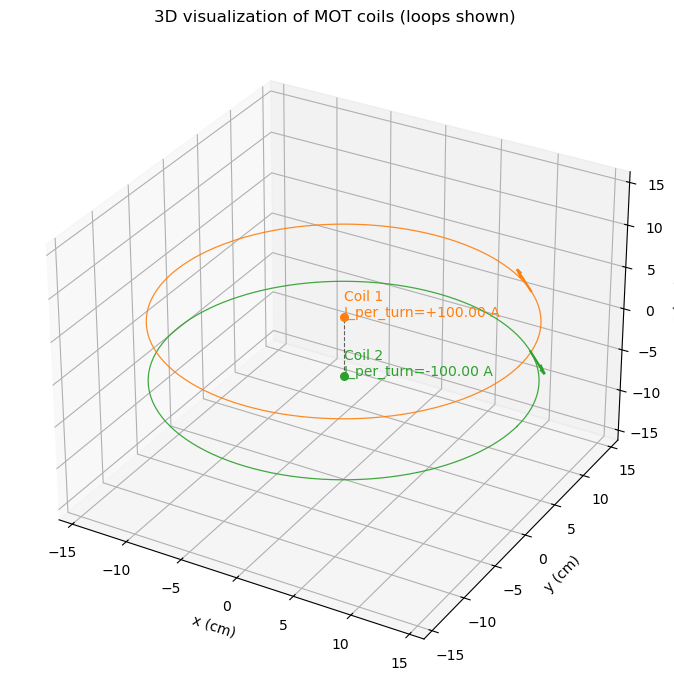

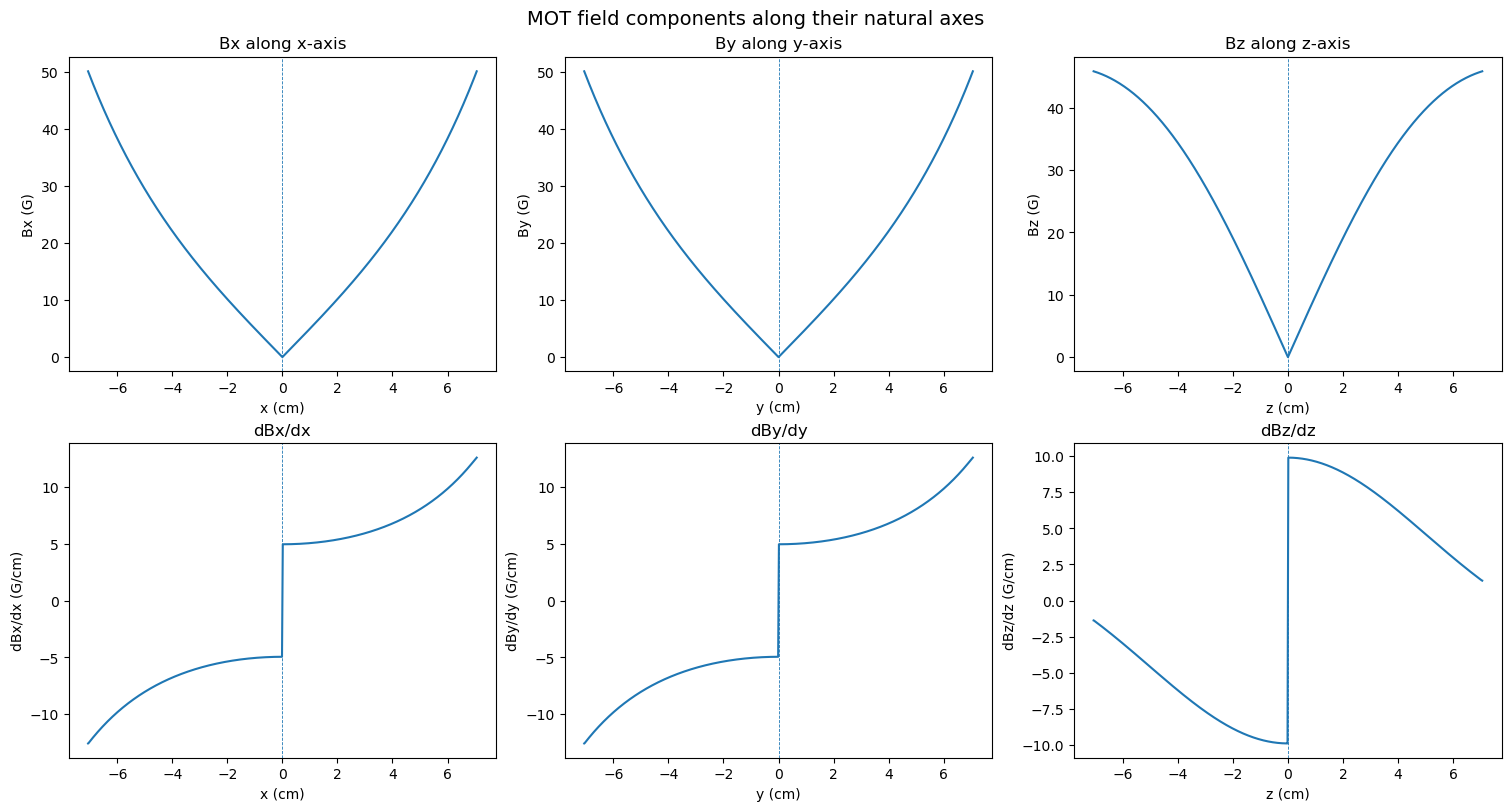

In [79]:
inch_to_m = 0.0254
# ---------------- USER INPUTS ----------------
radius = 6 * inch_to_m           # radius (m)
radial_thickness = 0.0*inch_to_m  # radial coil thickness (m)
axial_thickness  = 0.0*inch_to_m  # axial coil thickness (m)
sep = 2.78 * inch_to_m            # coil separation (m)
Nturns = 30                        # turns per coil

# Set current per turn for each coil independently (A per turn).
# Sign controls direction (positive = CCW for increasing theta in our visualization)
I_coil1_per_turn = 100.0   # A per turn in coil 1
I_coil2_per_turn = -100.0   # A per turn in coil 2

Nr = 8   # radial discretization for thick coil model (visual/accuracy)
Nz = 8   # axial discretization

# -------------------- AXIS-SPECIFIC FIELD SAMPLING --------------------

# axis ranges (meters)
xmax = sep
ymax = sep
zmax = sep

npts = 1001

x = np.linspace(-xmax, xmax, npts)
y = np.linspace(-ymax, ymax, npts)
z = np.linspace(-zmax, zmax, npts)

Bx_x = np.zeros(npts)
By_y = np.zeros(npts)
Bz_z = np.zeros(npts)

# --- Bx along x-axis (y=z=0) ---
for i, xx in enumerate(x):
    B = B_two_coils(
        xx, 0.0, 0.0,
        radius, radial_thickness, axial_thickness, sep,
        Nturns, I_coil1_per_turn, I_coil2_per_turn,
        Nr=Nr, Nz=Nz
    )
    Bx_x[i] = B[0]

# --- By along y-axis (x=z=0) ---
for i, yy in enumerate(y):
    B = B_two_coils(
        0.0, yy, 0.0,
        radius, radial_thickness, axial_thickness, sep,
        Nturns, I_coil1_per_turn, I_coil2_per_turn,
        Nr=Nr, Nz=Nz
    )
    By_y[i] = B[1]

# --- Bz along z-axis (x=y=0) ---
for i, zz in enumerate(z):
    B = B_two_coils(
        0.0, 0.0, zz,
        radius, radial_thickness, axial_thickness, sep,
        Nturns, I_coil1_per_turn, I_coil2_per_turn,
        Nr=Nr, Nz=Nz
    )
    Bz_z[i] = B[2]

Bx_x = np.abs(Bx_x)
By_y = np.abs(By_y)
Bz_z = np.abs(Bz_z)

# Gradients (SI: T/m)
dBx_dx = np.gradient(Bx_x, x)
dBy_dy = np.gradient(By_y, y)
dBz_dz = np.gradient(Bz_z, z)

# -------------------- UNIT CONVERSION --------------------
# Tesla -> Gauss
Bx_x *= 1e4
By_y *= 1e4
Bz_z *= 1e4

# T/m -> G/cm
dBx_dx *= 100
dBy_dy *= 100
dBz_dz *= 100

# Convert axes to cm
x_cm = x * 100
y_cm = y * 100
z_cm = z * 100

# print chosen configuration
print("Configuration:")
print(f" radius = {radius} m, radial_thickness = {radial_thickness} m, axial_thickness = {axial_thickness} m")
print(f" sep = {sep} m, Nturns = {Nturns}")
print(f" I per turn: coil1 = {I_coil1_per_turn:+.3f} A, coil2 = {I_coil2_per_turn:+.3f} A")
print(f" discretization for thick coil: Nr={Nr}, Nz={Nz}")
print()

# visualization settings
show_3d = True
loops_to_show = 1   # None => show all loops; otherwise choose representative subset
# optional 3D coil plot
if show_3d:
    plot_coils_3d(radius, radial_thickness, axial_thickness, sep,
                    Nturns, I_coil1_per_turn, I_coil2_per_turn,
                    Nr=Nr, Nz=Nz, loops_to_show=loops_to_show)


# -------------------- PLOTTING --------------------
fig, ax = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)

# Row 1: B components along their natural axes
ax[0,0].plot(x_cm, Bx_x)
ax[0,0].axvline(0, ls='--', lw=0.6)
ax[0,0].set_xlabel("x (cm)")
ax[0,0].set_ylabel("Bx (G)")
ax[0,0].set_title("Bx along x-axis")

ax[0,1].plot(y_cm, By_y)
ax[0,1].axvline(0, ls='--', lw=0.6)
ax[0,1].set_xlabel("y (cm)")
ax[0,1].set_ylabel("By (G)")
ax[0,1].set_title("By along y-axis")

ax[0,2].plot(z_cm, Bz_z)
ax[0,2].axvline(0, ls='--', lw=0.6)
ax[0,2].set_xlabel("z (cm)")
ax[0,2].set_ylabel("Bz (G)")
ax[0,2].set_title("Bz along z-axis")

# Row 2: corresponding gradients
ax[1,0].plot(x_cm, dBx_dx)
ax[1,0].axvline(0, ls='--', lw=0.6)
ax[1,0].set_xlabel("x (cm)")
ax[1,0].set_ylabel("dBx/dx (G/cm)")
ax[1,0].set_title("dBx/dx")

ax[1,1].plot(y_cm, dBy_dy)
ax[1,1].axvline(0, ls='--', lw=0.6)
ax[1,1].set_xlabel("y (cm)")
ax[1,1].set_ylabel("dBy/dy (G/cm)")
ax[1,1].set_title("dBy/dy")

ax[1,2].plot(z_cm, dBz_dz)
ax[1,2].axvline(0, ls='--', lw=0.6)
ax[1,2].set_xlabel("z (cm)")
ax[1,2].set_ylabel("dBz/dz (G/cm)")
ax[1,2].set_title("dBz/dz")

fig.suptitle("MOT field components along their natural axes", fontsize=14)
plt.show()


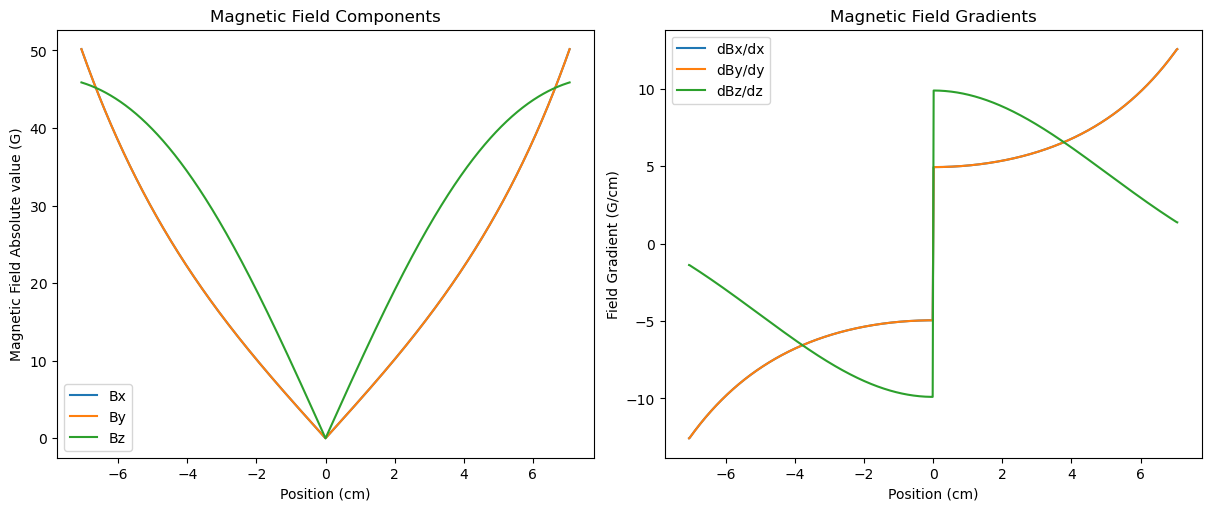

In [80]:
# make 2 plots, one with B components and one with gradients, to zoom in more on the gradient shapes
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# B components
ax[0].plot(x_cm, Bx_x, label='Bx')
ax[0].plot(y_cm, By_y, label='By')
ax[0].plot(z_cm, Bz_z, label='Bz')
ax[0].set_xlabel("Position (cm)")
ax[0].set_ylabel("Magnetic Field Absolute value (G)")
ax[0].set_title("Magnetic Field Components")
ax[0].legend()

# Gradients
ax[1].plot(x_cm, dBx_dx, label='dBx/dx')
ax[1].plot(y_cm, dBy_dy, label='dBy/dy')
ax[1].plot(z_cm, dBz_dz, label='dBz/dz')
ax[1].set_xlabel("Position (cm)")
ax[1].set_ylabel("Field Gradient (G/cm)")
ax[1].set_title("Magnetic Field Gradients")
ax[1].legend()


